# Analysis for *Machine learning predicts putative haematopoietic stem cells within large single-cell transcriptomics datasets*

This notebook contains code used for training the models after GridSearchCV was used to identify the best parameters for each model. Trained models were then applied to several different published datasets. Locations of where input data can be downloaded are described in the notebook.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

import ast
import re
import pickle
import gc

import scipy.stats as stats

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# Prediction models
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

# Model training
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Statistical tests and data handling
from scipy.sparse import issparse
from scipy.stats import ranksums

# Plotting settings
mpl.rcParams['figure.figsize'] = [4.5, 4.5]
mpl.rcParams['grid.alpha'] = 0.0

# Logging
sc.logging.print_version_and_date()
sc.logging.print_versions()
sc.settings.verbosity = 'error'
sc.set_figure_params()

Running Scanpy 1.4.3 on 2019-07-10 15:59.
scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Analyse GridSearchCV results

Load the parameter search results

In [2]:
param_search_file = './Data/table_S3_model_selection_cv_scores.txt'
param_search = pd.read_csv(param_search_file, sep='\t')
param_search = param_search.sort_values(by='Average_score', ascending=False)
param_search.head()

Gene_set Normalisation  PCA    Model  \
28     Molo       Ranking   No      mlp   
29     Molo   Total_count   No      mlp   
46     Molo       Ranking  Yes  svm_pca   
16     Molo       Ranking   No      svm   
59     Molo   Total_count  Yes  mlp_pca   

                                      Best_parameters  cv_1_score  cv_2_score  \
28  {'regr__activation': 'logistic', 'regr__alpha'...    0.695653    0.724024   
29  {'regr__activation': 'logistic', 'regr__alpha'...    0.634148    0.663834   
46  {'pca__n_components': 50, 'regr__C': 0.1, 'reg...    0.637567    0.665368   
16  {'regr__C': 0.1, 'regr__coef0': 1, 'regr__degr...    0.655499    0.636573   
59  {'pca__n_components': 20, 'regr__activation': ...    0.750549    0.716239   

    cv_3_score  cv_4_score  cv_5_score  Average_score        SD  \
28    0.569320    0.747022    0.503177       0.649936  0.093951   
29    0.691793    0.746702    0.417534       0.633893  0.110741   
46    0.526235    0.795309    0.410763       0.609893  0.129020   
16    0.531372    0.780297    0.412075       0.605932  0.122744   
59    0.686601    0.657609    0.181463       0.604536  0.206200   

    Score_on_test_data  
28            0.728088  
29            0.730717  
46            0.672449  
16            0.671373  
59            0.731794

Tidy up the model names

In [3]:
param_search['Model'] = [s.replace('_pca', '') for s in param_search['Model']]
param_search.head()

Gene_set Normalisation  PCA Model  \
28     Molo       Ranking   No   mlp   
29     Molo   Total_count   No   mlp   
46     Molo       Ranking  Yes   svm   
16     Molo       Ranking   No   svm   
59     Molo   Total_count  Yes   mlp   

                                      Best_parameters  cv_1_score  cv_2_score  \
28  {'regr__activation': 'logistic', 'regr__alpha'...    0.695653    0.724024   
29  {'regr__activation': 'logistic', 'regr__alpha'...    0.634148    0.663834   
46  {'pca__n_components': 50, 'regr__C': 0.1, 'reg...    0.637567    0.665368   
16  {'regr__C': 0.1, 'regr__coef0': 1, 'regr__degr...    0.655499    0.636573   
59  {'pca__n_components': 20, 'regr__activation': ...    0.750549    0.716239   

    cv_3_score  cv_4_score  cv_5_score  Average_score        SD  \
28    0.569320    0.747022    0.503177       0.649936  0.093951   
29    0.691793    0.746702    0.417534       0.633893  0.110741   
46    0.526235    0.795309    0.410763       0.609893  0.129020   
16    0.531372    0.780297    0.412075       0.605932  0.122744   
59    0.686601    0.657609    0.181463       0.604536  0.206200   

    Score_on_test_data  
28            0.728088  
29            0.730717  
46            0.672449  
16            0.671373  
59            0.731794

Plot these results

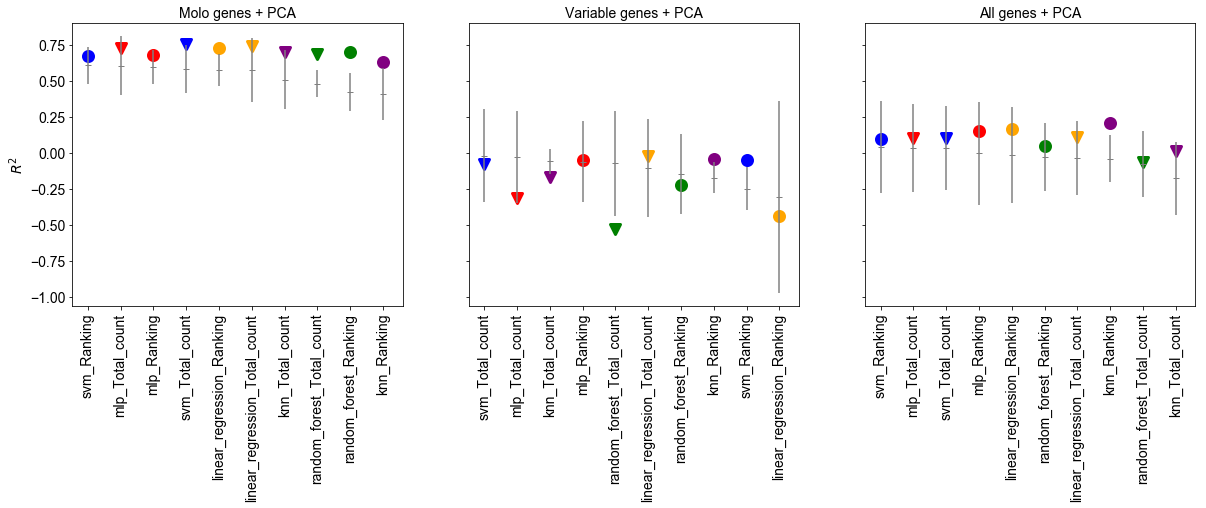

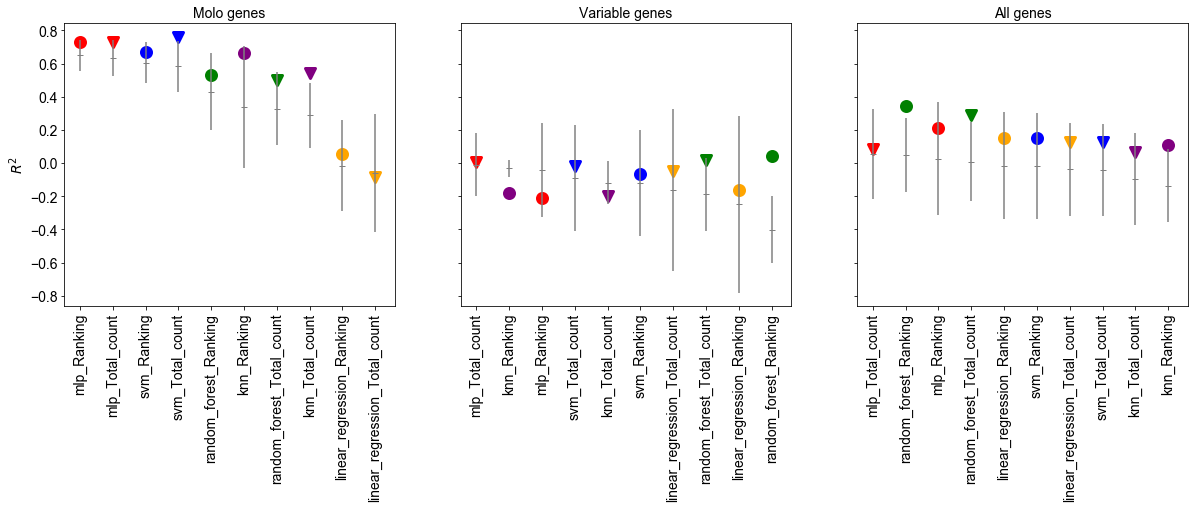

In [4]:
for pca in ['Yes', 'No']:
    shape_dict = {'Ranking': 'o',
                  'Total_count': 'v'}
    col_dict = {'random_forest': 'green',
                'svm': 'blue',
                'knn': 'purple',
                'linear_regression': 'orange',
                'mlp': 'red'}

    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 5))

    for n, geneset in enumerate(['Molo', 'Variable', 'All']):

        y = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['Average_score']
        yerr = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['SD']
        y_test = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['Score_on_test_data']
        x = range(len(y))

        norm_type = [norm for norm in param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['Normalisation']]
        model_type = [model for model in param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['Model']]
        shape = [shape_dict[norm] for norm in norm_type]
        col = [col_dict[model] for model in model_type]

        xlab = [model + '_' + norm_type[i] for i, model in enumerate(model_type)]

        for i in range(len(y)):
            axs[n].scatter(x[i], y_test.iloc[i], c=col[i], marker=shape[i], s=100, linewidths=3)
            axs[n].errorbar(x[i], y.iloc[i], yerr.iloc[i], c='grey', marker='_')

        axs[n].set_xticks(x)
        axs[n].set_xticklabels(xlab, rotation='vertical')

        plt_title = geneset + ' genes'
        if pca == 'Yes':
            plt_title += ' + PCA'
        axs[n].set_title(plt_title)
        axs[0].set_ylabel("$R^2$")

Make plots of the different cv values

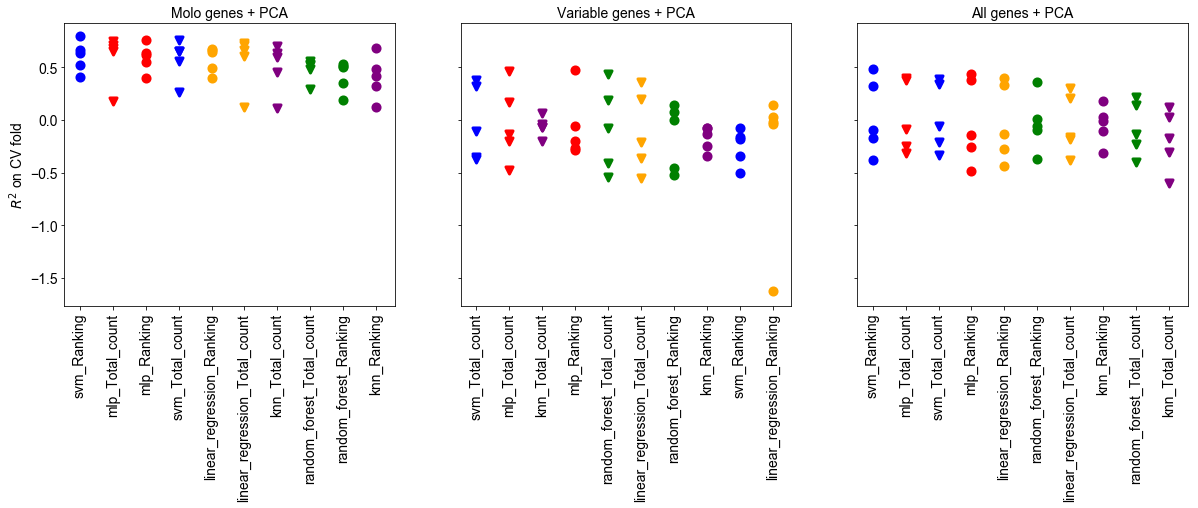

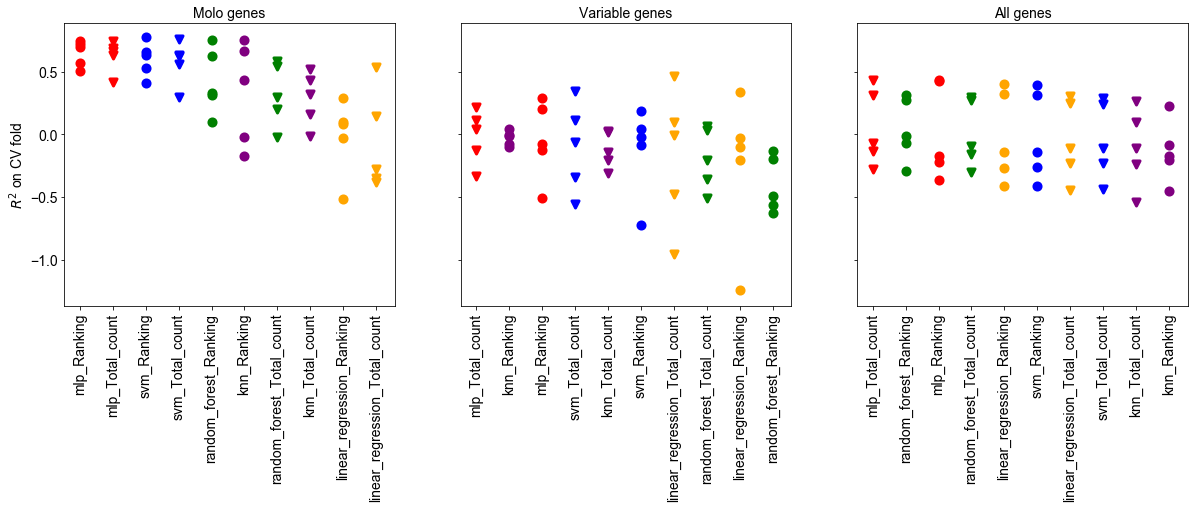

In [5]:
for pca in ['Yes', 'No']:
    shape_dict = {'Ranking': 'o',
                  'Total_count': 'v'}
    col_dict = {'random_forest': 'green',
                'svm': 'blue',
                'knn': 'purple',
                'linear_regression': 'orange',
                'mlp': 'red'}

    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 5))

    for n, geneset in enumerate(['Molo', 'Variable', 'All']):

        y1 = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['cv_1_score']
        y2 = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['cv_2_score']
        y3 = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['cv_3_score']
        y4 = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['cv_4_score']
        y5 = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['cv_5_score']
        y_test = param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['Score_on_test_data']
        x = range(len(y1))

        norm_type = [norm for norm in param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['Normalisation']]
        model_type = [model for model in param_search.loc[
            np.logical_and(param_search['Gene_set'] == geneset, param_search['PCA'] == pca)]['Model']]
        shape = [shape_dict[norm] for norm in norm_type]
        col = [col_dict[model] for model in model_type]

        xlab = [model + '_' + norm_type[i] for i, model in enumerate(model_type)]

        for i in range(len(y)):
            axs[n].scatter(x[i], y1.iloc[i], c=col[i], marker=shape[i], s=50, linewidths=3)
            axs[n].scatter(x[i], y2.iloc[i], c=col[i], marker=shape[i], s=50, linewidths=3)
            axs[n].scatter(x[i], y3.iloc[i], c=col[i], marker=shape[i], s=50, linewidths=3)
            axs[n].scatter(x[i], y4.iloc[i], c=col[i], marker=shape[i], s=50, linewidths=3)
            axs[n].scatter(x[i], y5.iloc[i], c=col[i], marker=shape[i], s=50, linewidths=3)

        axs[n].set_xticks(x)
        axs[n].set_xticklabels(xlab, rotation='vertical')

        plt_title = geneset + ' genes'
        if pca == 'Yes':
            plt_title += ' + PCA'
        axs[n].set_title(plt_title)
        axs[0].set_ylabel("$R^2$ on CV fold")

Make just MolO gene plots

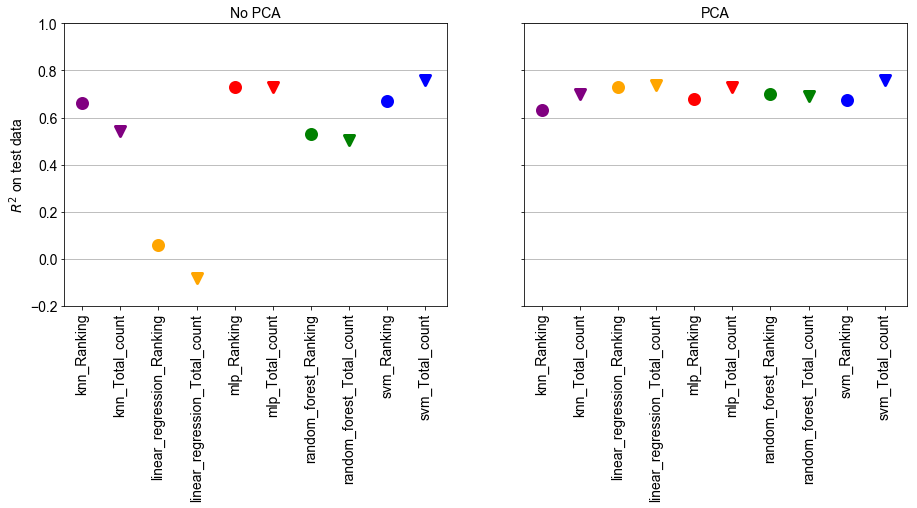

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
    
for n, pca in enumerate(['No', 'Yes']):
    shape_dict = {'Ranking': 'o',
                  'Total_count': 'v'}
    col_dict = {'random_forest': 'green',
                'svm': 'blue',
                'knn': 'purple',
                'linear_regression': 'orange',
                'mlp': 'red'}
    param_search_sort = param_search.copy()
    param_search_sort = param_search_sort.sort_values(by=['Model', 'Normalisation'])
    
    y_test = param_search_sort.loc[
        np.logical_and(param_search_sort['Gene_set'] == "Molo", param_search_sort['PCA'] == pca)]['Score_on_test_data']
    x = range(len(y))

    norm_type = [norm for norm in param_search_sort.loc[
        np.logical_and(param_search_sort['Gene_set'] == "Molo", param_search_sort['PCA'] == pca)]['Normalisation']]
    model_type = [model for model in param_search_sort.loc[
        np.logical_and(param_search_sort['Gene_set'] == "Molo", param_search_sort['PCA'] == pca)]['Model']]
    shape = [shape_dict[norm] for norm in norm_type]
    col = [col_dict[model] for model in model_type]

    xlab = [model + '_' + norm_type[i] for i, model in enumerate(model_type)]

    for i in range(len(y)):
        axs[n].scatter(x[i], y_test.iloc[i], c=col[i], marker=shape[i], s=100, linewidths=3)

    axs[n].set_xticks(x)
    axs[n].set_xticklabels(xlab, rotation='vertical')
    axs[n].set_ylim((-0.2, 1))
    
    axs[0].set_ylabel("$R^2$ on test data")
    
    if pca == 'Yes':
        pca_title = 'PCA'
        
    if pca == 'No':
        pca_title = 'No PCA'
        
    axs[n].set_title(pca_title)
    axs[n].yaxis.grid(linestyle='-', linewidth='0.5', color='grey', alpha=1)


## Take the ten best models and re-train on all of data from [Wilson et al. (2015)](https://doi.org/10.1016/j.stem.2015.04.004)

Define the alternative normalisation functions applied to count data 

In [7]:
# Rank normalisation function
def rank_normalise_genes(adata):
    
    exprs = pd.DataFrame(adata.X)
    ranked = exprs.rank(axis=1, method='average')
    ranked = np.array(ranked)
    
    adata_ranked = adata.copy()
    adata_ranked.X = ranked
    
    return(adata_ranked)

# Total_count normalisation function
def total_count_normalised(adata, target_sum):
    
    adata_total_count = adata.copy()
    sc.pp.normalize_total(adata_total_count, target_sum=target_sum)
    sc.pp.log1p(adata_total_count)
    
    return(adata_total_count)

Load [Wilson et al. (2015)](https://doi.org/10.1016/j.stem.2015.04.004) training data.

- wilson_HTSEQ_results.txt - [HTSeq](https://htseq.readthedocs.io/en/release_0.11.1/) output from analysis for [Wilson et al. (2015)](https://doi.org/10.1016/j.stem.2015.04.004) paper. Genes x cells count matrix.
- wilson_rna_seq_hsc_scores.csv - HSC-scores from [Wilson et al. (2015)](https://doi.org/10.1016/j.stem.2015.04.004) as a result of applying random forest classifier to scRNA-seq profiles
- ensembl_gene_table_81.txt - Annotated gene table downloaded from [Ensembl 81](http://jul2015.archive.ensembl.org/index.html) matching Ensembl gene IDs to common gene names and their gene type annotation.

In [8]:
data_dir = './Data/'
downloaded_data_dir = './Downloaded_data/'

# Counts data
wilson_counts = sc.read(data_dir + 'wilson_HTSEQ_results.txt').transpose()

# Gene table
gene_table = pd.read_csv(data_dir + 'ensembl_gene_table_81.txt', index_col=1, sep='\t')

# Filter to protein coding and not mitochondrial RNA
protein_coding_genes = gene_table[gene_table['Gene type'] == 'protein_coding']
protein_coding_nuclear = list(protein_coding_genes[
    [gene[0:3] != 'mt-' for gene in protein_coding_genes.index]].index)

wilson_counts = sc.AnnData(wilson_counts[:, np.array([gene in protein_coding_nuclear for gene in wilson_counts.var_names])])

# MolO scores
molo_scores = pd.read_csv(data_dir + 'wilson_rna_seq_hsc_scores.csv', index_col=1)

# Make names consistent
molo_scores.index = [cell.replace("SLX.", "SLX-") for cell in molo_scores.index]

# Filter to cells that have been MolO scored
molo_scored_cells = molo_scores.index
wilson_scored = [cell in molo_scored_cells for cell in wilson_counts.obs_names]
wilson_counts = sc.AnnData(wilson_counts[np.array(wilson_scored), :])

wilson_counts.obs['hsc_score'] = molo_scores['molo_score'].loc[wilson_counts.obs_names]
wilson_counts.obs['PC1'] = molo_scores['PC1'].loc[wilson_counts.obs_names]
wilson_counts.obs['PC2'] = molo_scores['PC2'].loc[wilson_counts.obs_names]

# Subset to Molo genes
molo_genes = pd.read_csv(data_dir + 'wilson_nomo_molo_genes.csv')
molo_gene_list =  [gene for gene in wilson_counts.var_names if gene in list(molo_genes['Gene'])]
model_molo_gene_file = data_dir + 'model_molo_genes.txt'
with open(model_molo_gene_file, 'w') as f:
    for gene in molo_gene_list:
        f.writelines('%s\n' %gene)

# Normalise in two alternative ways
wilson_adata_molo_rank = wilson_counts.copy()
wilson_adata_molo_rank = sc.AnnData(wilson_adata_molo_rank[:, molo_gene_list])
wilson_adata_molo_rank = rank_normalise_genes(wilson_adata_molo_rank)

wilson_adata_molo_total_count = wilson_counts.copy()
wilson_adata_molo_total_count = sc.AnnData(wilson_adata_molo_total_count[:, molo_gene_list])
target_sum_molo = np.median(np.sum(wilson_adata_molo_total_count.X, axis=1))
wilson_adata_molo_total_count = total_count_normalised(wilson_adata_molo_total_count, target_sum=target_sum_molo)

Plot HSC-score on PCA coordinates from [Wilson et al. (2015)](https://doi.org/10.1016/j.stem.2015.04.004)

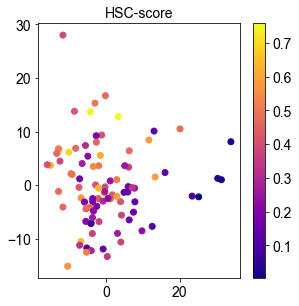

In [11]:
plt.scatter(wilson_counts.obs['PC1'], wilson_counts.obs['PC2'],
            c=wilson_counts.obs['hsc_score'], cmap='plasma')
plt.title('HSC-score')
plt.colorbar()
plt.show()

Define function to fit model on all Wilson et al. (2015) data using the best parameters identified from GridSearchCV.

In [12]:
def fit_best_model(gene_set_choice, norm_choice, pca_choice, model_choice,
                   specific_adata=None, specific_X=None, specific_y=None):
    
    default_model_dictionary = {'random_forest': RandomForestRegressor(random_state=0, n_estimators=100),
                                'svm': svm.SVR(gamma='auto'),
                                'knn': KNeighborsRegressor(),
                                'linear_regression': LinearRegression(),
                                'mlp': MLPRegressor(random_state=0)}
    
    i = list(set(param_search.index[param_search['Gene_set'] == gene_set_choice].tolist()) & set(
        param_search.index[param_search['Normalisation'] == norm_choice].tolist()) & set(
        param_search.index[param_search['PCA'] == pca_choice].tolist()) & set(
        param_search.index[param_search['Model'] == model_choice].tolist()))[0]
    
    # Extract the best parameter choices for your model
    param_choices = param_search.loc[i]

    gene_set = param_choices['Gene_set']
    if gene_set != 'Molo':
        print('error')
        
    norm = param_choices['Normalisation']
    pca = param_choices['PCA']
    model = param_choices['Model']
    model_parameters = ast.literal_eval(param_choices['Best_parameters'])
    
    # Get the default parameters for the model
    regr = default_model_dictionary[model]

    # Make pipeline for fitting model (different whether using PCA pre-processing or not)
    if pca == 'Yes':
        regr_model = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA()),
                                     ('regr', regr)])
    elif pca == 'No':
        regr_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('regr', regr)])
    else:
        print('error')
    
    # Decide which data normalisation to use
    if specific_adata is not None:
        X = specific_adata.X
        y = specific_adata.obs['hsc_score']
        
    elif specific_X is not None:
        X = specific_X
        y = specific_y
    
    else:
        if norm == 'Total_count':
            X = wilson_adata_molo_total_count.X
            y = wilson_adata_molo_total_count.obs['hsc_score']

        elif norm == 'Ranking':
            X = wilson_adata_molo_rank.X
            y = wilson_adata_molo_rank.obs['hsc_score'] 

        else:
            print('error')

    # Fit model
    regr_model.set_params(**model_parameters)
    regr_model.fit(X, y)
    
    return(regr_model)

Train the 10 best scoring models

In [13]:
model_scoring_criterion = param_search['Score_on_test_data']
idx_10_best_models = np.argsort(np.array(model_scoring_criterion))[-10:]

best_scoring_models = param_search.iloc[idx_10_best_models]

top_10_models = {}

for i in range(10):
    model_info = best_scoring_models.iloc[i]
    norm_method = 'total_count' if model_info['Normalisation'] == 'Total_count' else 'rank'
    
    if model_info['PCA'] == 'No':
        model_name = model_info['Model'] + '_' + norm_method
    else:
        model_name = model_info['Model'] + '_' + norm_method + '_pca'
    model = fit_best_model(gene_set_choice=model_info['Gene_set'],
                           norm_choice=model_info['Normalisation'],
                           pca_choice=model_info['PCA'],
                           model_choice=model_info['Model'])
    top_10_models[model_name] = model

## Predictions on [Nestorowa et al. (2016)](https://doi.org/10.1182/blood-2016-05-716480) data

To test the trained models on a different dataset we consider the Smart-seq2 scRNA-seq data from Nestorowa et al. (2016) profiling ~1,600 blood stem and progenitor cells from mouse bone marrow. The data were downloaded from the following locations:

- nestorowa_htseq_counts_all_cells_gene_names_renamed.txt - Count data for Nestorowa et al. (2016)
- coordinates_gene_counts_flow_cytometry.txt - This file contains the diffusion map co-ordinates which we use for plotting and can be downloaded from http://blood.stemcells.cam.ac.uk/single_cell_atlas.html 

In [14]:
# Load HT-seq counts
nestorowa_adata = sc.read(data_dir + 'nestorowa_htseq_counts_all_cells_gene_names_renamed.txt', cache=True).T

# Change cell names to make compatible with downloaded co-ordinages
nestorowa_adata.obs_names = [cell_name.replace('-', '.') for cell_name in nestorowa_adata.obs_names]

# Read in diffusion map coords to subset data to those that have passed QC
nestorowa_meta_data = pd.read_csv(downloaded_data_dir + 'coordinates_gene_counts_flow_cytometry.txt', sep='\t',
                                  index_col=0)
nestorowa_meta_data['DC2'] = -nestorowa_meta_data['DC2']
nestorowa_meta_data['DC3'] = -nestorowa_meta_data['DC3']
nestorowa_adata = sc.AnnData(nestorowa_adata[nestorowa_meta_data.index])

nestorowa_adata.obsm['X_diffmap'] = np.array(nestorowa_meta_data[['DC1', 'DC2', 'DC3']])

# Subset to MolO genes
nestorowa_adata_molo = sc.AnnData(nestorowa_adata[:, wilson_adata_molo_rank.var_names])

# Normalise in the two different ways
nestorowa_adata_molo_rank = nestorowa_adata_molo.copy()
nestorowa_adata_molo_rank = rank_normalise_genes(nestorowa_adata_molo_rank)

nestorowa_adata_molo_total_count = nestorowa_adata_molo.copy()
nestorowa_adata_molo_total_count = total_count_normalised(nestorowa_adata_molo_total_count, target_sum_molo)

# For plotting
sc.pp.normalize_per_cell(nestorowa_adata)
sc.pp.log1p(nestorowa_adata)

Predict the HSC-score using the 10 best models trained on Wilson et al. (2015) data

In [15]:
for model_name, model in top_10_models.items():

    if 'total_count' in model_name:
        nestorowa_predict = model.predict(nestorowa_adata_molo_total_count.X)
    
    elif 'rank' in model_name:
        nestorowa_predict = model.predict(nestorowa_adata_molo_rank.X)
        
    nestorowa_adata.obs[model_name] = nestorowa_predict

Add cell type annotation from Nestorowa et al. (2016). This annotation is in the "all_cell_types.txt" file that can be downloaded from the data website (http://blood.stemcells.cam.ac.uk/single_cell_atlas.html).

In [16]:
nestorowa_cell_type_file = downloaded_data_dir + 'all_cell_types.txt'
nestorowa_cell_type = pd.read_csv(nestorowa_cell_type_file, sep="\t")
nestorowa_cell_type = nestorowa_cell_type.reindex(nestorowa_adata.obs_names)
nestorowa_cell_type.head()

LTHSC_broad  LMPP_broad  MPP_broad  CMP_broad  MEP_broad  GMP_broad  \
HSPC_001          0.0         0.0        1.0        0.0        0.0        0.0   
HSPC_002          1.0         0.0        0.0        0.0        0.0        0.0   
HSPC_003          0.0         0.0        1.0        0.0        0.0        0.0   
HSPC_004          0.0         1.0        0.0        0.0        0.0        0.0   
HSPC_006          0.0         1.0        0.0        0.0        0.0        0.0   

          MPP1_broad  MPP2_broad  MPP3_broad  STHSC_broad  ...  CMP  MEP  GMP  \
HSPC_001         0.0         0.0         0.0          1.0  ...  0.0  0.0  0.0   
HSPC_002         0.0         0.0         0.0          0.0  ...  0.0  0.0  0.0   
HSPC_003         0.0         0.0         1.0          0.0  ...  0.0  0.0  0.0   
HSPC_004         0.0         0.0         0.0          0.0  ...  0.0  0.0  0.0   
HSPC_006         0.0         0.0         0.0          0.0  ...  0.0  0.0  0.0   

          MPP1  MPP2  MPP3  STHSC  ESLAM  HSC1  Projected  
HSPC_001   0.0   0.0   0.0    0.0    0.0   0.0        0.0  
HSPC_002   0.0   0.0   0.0    0.0    0.0   0.0        0.0  
HSPC_003   0.0   0.0   0.0    0.0    0.0   0.0        0.0  
HSPC_004   0.0   0.0   0.0    0.0    0.0   0.0        0.0  
HSPC_006   0.0   0.0   0.0    0.0    0.0   0.0        0.0  

[5 rows x 23 columns]

In [17]:
nestorowa_cell_type_simple = ['None' for i in range(nestorowa_cell_type.shape[0])]

# Paper has broad and narrow annotations - here using broad to get more cells per category
for ct in ['LTHSC_broad', 'LMPP_broad', 'CMP_broad', 'MEP_broad', 'GMP_broad', 'MPP1_broad',
           'MPP2_broad', 'MPP3_broad', 'STHSC_broad', 'ESLAM']:
    for i, cell_type in enumerate(nestorowa_cell_type[ct]):
        if cell_type:
            nestorowa_cell_type_simple[i] = ct
            
# Remove broad from labels for plotting
nestorowa_cell_type_simple = [ct.replace('_broad', '') for ct in nestorowa_cell_type_simple]

cell_type_order = ['ESLAM', 'LTHSC', 'STHSC', 'MPP1', 'MPP2', 'MPP3',
                   'LMPP', 'CMP', 'GMP', 'MEP']
nestorowa_cell_type_simple = pd.Categorical(nestorowa_cell_type_simple,
                                            categories=cell_type_order)

nestorowa_adata.obs['cell_type'] = nestorowa_cell_type_simple
cell_type_colors = ['#521b92', '#dbd4ff', '#f69e02', '#973330', '#fd97fe', '#fff200',
                    '#3364ca', '#6cf9cc', '#02cc04', '#f30301']
nestorowa_adata.uns['cell_type_colors'] = cell_type_colors

Plot diffusion map coloured by cell type

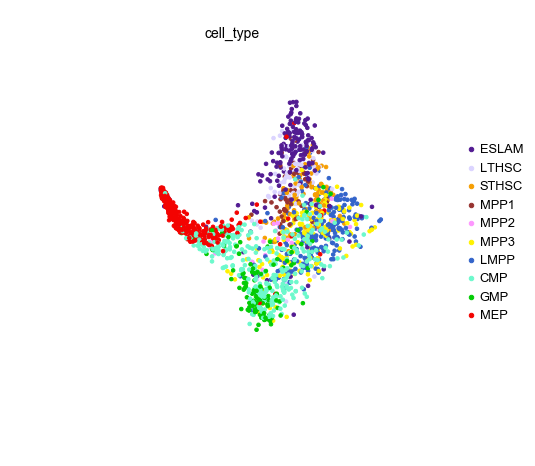

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
sc.pl.diffmap(nestorowa_adata, components='2,0,1', 
              color='cell_type', size=50, projection='3d', show=False, alpha=1, ax=ax,
              edgecolor='face')
ax.grid(False)
ax.view_init(10, 150)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.axis('off')
plt.show()

Plot HSC-score on the diffusion map

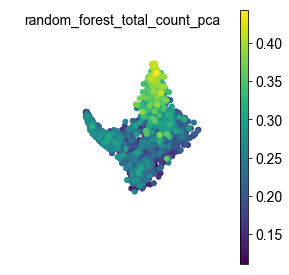

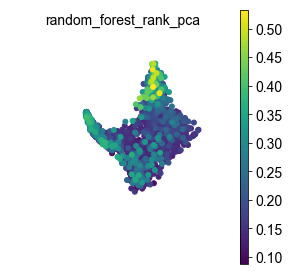

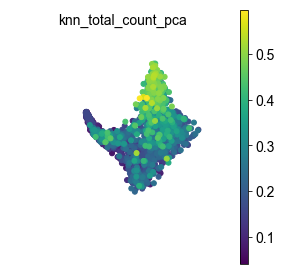

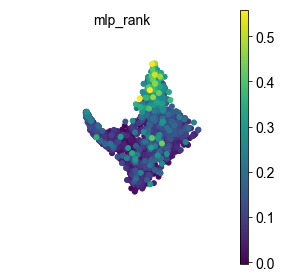

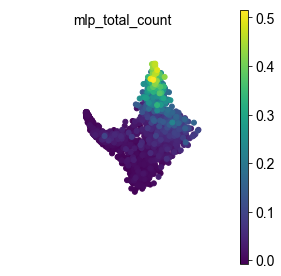

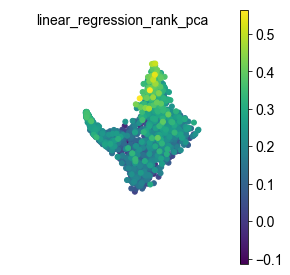

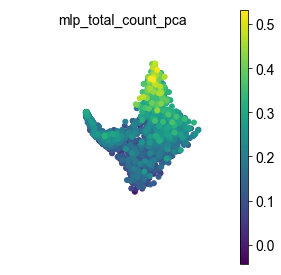

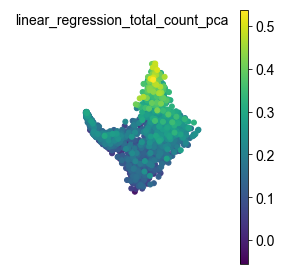

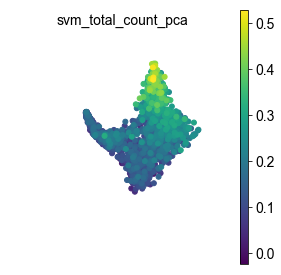

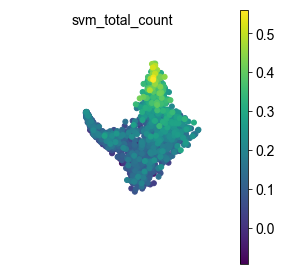

In [19]:
for score, _ in top_10_models.items():
    ax = sc.pl.diffmap(nestorowa_adata, components='2,0,1',
                       color=score, size=100, projection='3d', show=False, alpha=1, edgecolor='face')

    ax.grid(False)
    ax.view_init(10, 150)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')

Plot distribution of scores across cell types and test significance

<Figure size 432x720 with 0 Axes>

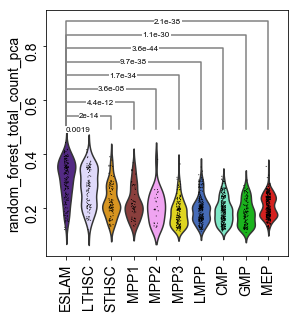

<Figure size 432x720 with 0 Axes>

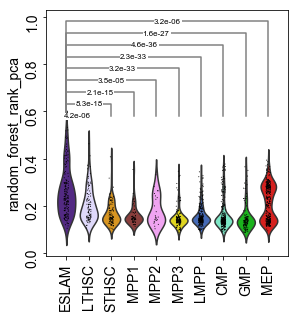

<Figure size 432x720 with 0 Axes>

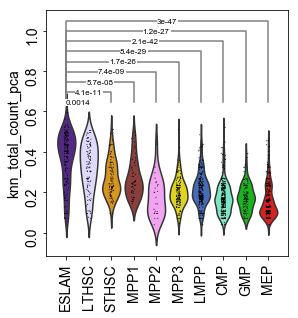

<Figure size 432x720 with 0 Axes>

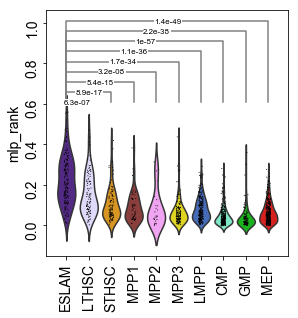

<Figure size 432x720 with 0 Axes>

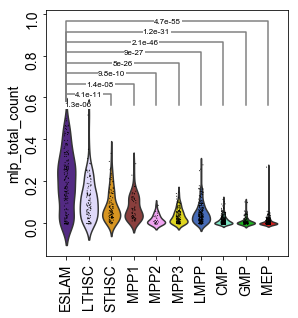

<Figure size 432x720 with 0 Axes>

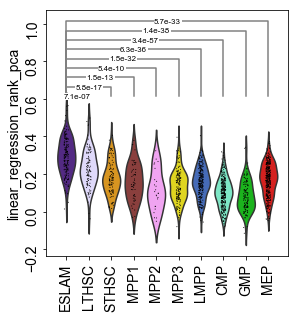

<Figure size 432x720 with 0 Axes>

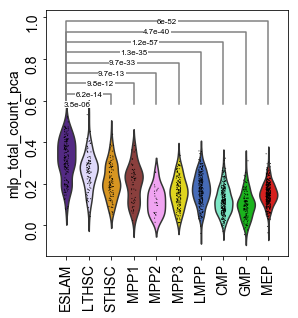

<Figure size 432x720 with 0 Axes>

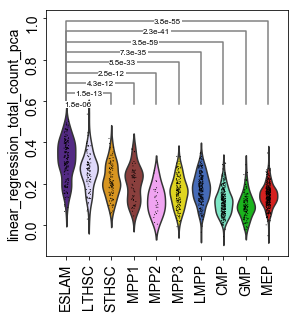

<Figure size 432x720 with 0 Axes>

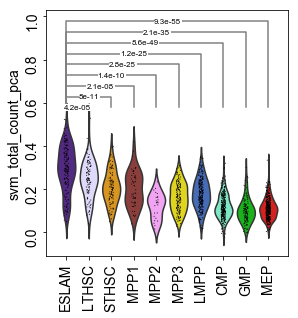

<Figure size 432x720 with 0 Axes>

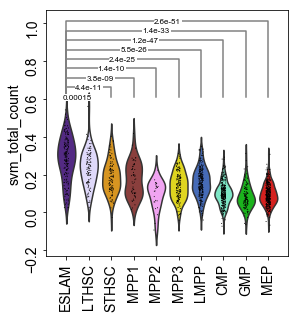

In [20]:
for model, _ in top_10_models.items():
    
    # Test signficance of difference between eslam scores and other cell types
    eslam_scores = nestorowa_adata.obs[model][nestorowa_adata.obs['cell_type'] == 'ESLAM']
    significance_comparison = {}
    for ct in ['LTHSC', 'STHSC', 'MPP1', 'MPP2', 'MPP3',
               'LMPP', 'CMP', 'GMP', 'MEP']:
        ct_scores = nestorowa_adata.obs[model][nestorowa_adata.obs['cell_type'] == ct]
        
        pval = ranksums(eslam_scores, ct_scores)[1]
        significance_comparison[ct] = pval
    
    fig = plt.figure(figsize=(6, 10))
    sc.pl.violin(nestorowa_adata, keys=model, groupby='cell_type', rotation=90,
                 palette=nestorowa_adata.uns['cell_type_colors'], show=False, )
    
    # Add annotation to plot
    for i, ct in enumerate(['LTHSC', 'STHSC', 'MPP1', 'MPP2', 'MPP3',
                            'LMPP', 'CMP', 'GMP', 'MEP']):
        
        mean_eslam_scores = np.mean(eslam_scores)
        mean_ct_scores = np.mean(nestorowa_adata.obs[model][nestorowa_adata.obs['cell_type'] == ct])
        
        if mean_eslam_scores > mean_ct_scores:
        
            sig = '%s' % float('%.2g' % significance_comparison[ct])
            h = 0.05*i
            x1 = 0
            x2 = i + 1
            y = np.max(nestorowa_adata.obs[model]) + 0.05
            y2 = np.max(nestorowa_adata.obs[model][nestorowa_adata.obs['cell_type'] == ct]) + 0.1

            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='grey')
            plt.text((x1 + x2)*.5, y + h, sig, ha='center', va='center', size=8,
                     bbox=dict(facecolor='white', pad=0, ec='white'))

Rule out models doing very badly on this dataset for testing on further datasets

In [21]:
top_models = top_10_models.copy()
top_models.pop('random_forest_rank_pca')
top_models.pop('random_forest_total_count_pca')

# remaining models
top_models.keys()

dict_keys(['knn_total_count_pca', 'mlp_rank', 'mlp_total_count', 'linear_regression_rank_pca', 'mlp_total_count_pca', 'linear_regression_total_count_pca', 'svm_total_count_pca', 'svm_total_count'])

## Predictions on [Dahlin et al. (2018)](https://doi.org/10.1182/blood-2017-12-821413 ) 10x data

We also wanted to test the HSC-scoring methods, trained on plate-based Smart-Seq2 data, on a different type of scRNA-seq data. For this we used data we published in [Dahlin et al. (2018)](https://doi.org/10.1182/blood-2017-12-821413) which were generated using the [10x genomics](https://www.10xgenomics.com/solutions/single-cell/) droplet-based scRNA-seq method. These data consist of 44,802 cells from the Lin<sup>-</sup> c-Kit<sup>+</sup> (21,809 cells) and Lin<sup>-</sup> Sca1<sup>+</sup> c-Kit<sup>+</sup> (22,993 cells) gates. Visualisation and annotation from the original paper identified stem cells and entry points to 8 different blood lineages within the data.

<img src="./Images/dahlin_cell_type_annotation.png">

Image from [Dahlin et al. (2018)](https://doi.org/10.1182/blood-2017-12-821413)

Count data can be obtained from GEO [GSE107727](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE107727) by downloading the GSE107727_RAW.tar file. This contains 8 samples:
- GSM2877127_SIGAB1_counts.txt.gz - LSK WT cells
- GSM2877128_SIGAC1_counts.txt.gz - LSK WT cells
- GSM2877129_SIGAD1_counts.txt.gz - LSK WT cells
- GSM2877130_SIGAF1_counts.txt.gz - LK WT cells
- GSM2877131_SIGAG1_counts.txt.gz - LK WT cells
- GSM2877132_SIGAH1_counts.txt.gz - LK WT cells
- GSM2877133_SIGAG8_counts.txt.gz - LK W<sup>41</sup>/W<sup>41</sup> cells
- GSM2877134_SIGAH8_counts.txt.gz - LK W<sup>41</sup>/W<sup>41</sup> cells

We also used the force-directed graph co-ordinates calculated in the original publication for visualisation. These can be downloaded from the data website (https://gottgens-lab.stemcells.cam.ac.uk/adultHSPC10X/).
- coords_WT_LK_LSK.txt - graph co-ordinates for WT LSK + LK sample
- coords_WT_LK.txt - graph co-ordinates for WT LK sample
- coords_W41_LK.txt - graph co-ordinates for W<sup>41</sup>/W<sup>41</sup> LK sample

In [22]:
# Read in WT count data
dahlin_adata_SIGAB1 = sc.read(downloaded_data_dir + 'GSM2877127_SIGAB1_counts.txt.gz', cache=True).T
dahlin_adata_SIGAB1.X = sp.sparse.csr_matrix(dahlin_adata_SIGAB1.X)
dahlin_adata_SIGAB1.obs_names = [cell_name + '_SIGAB1' for cell_name in dahlin_adata_SIGAB1.obs_names]
dahlin_adata_SIGAB1.obs['exp_group'] = 'LSK'

dahlin_adata_SIGAC1 = sc.read(downloaded_data_dir + 'GSM2877128_SIGAC1_counts.txt.gz', cache=True).T
dahlin_adata_SIGAC1.X = sp.sparse.csr_matrix(dahlin_adata_SIGAC1.X)
dahlin_adata_SIGAC1.obs_names = [cell_name + '_SIGAC1' for cell_name in dahlin_adata_SIGAC1.obs_names]
dahlin_adata_SIGAC1.obs['exp_group'] = 'LSK'

dahlin_adata_SIGAD1 = sc.read(downloaded_data_dir + 'GSM2877129_SIGAD1_counts.txt.gz', cache=True).T
dahlin_adata_SIGAD1.X = sp.sparse.csr_matrix(dahlin_adata_SIGAD1.X)
dahlin_adata_SIGAD1.obs_names = [cell_name + '_SIGAD1' for cell_name in dahlin_adata_SIGAD1.obs_names]
dahlin_adata_SIGAD1.obs['exp_group'] = 'LSK'

dahlin_adata_SIGAF1 = sc.read(downloaded_data_dir + 'GSM2877130_SIGAF1_counts.txt.gz', cache=True).T
dahlin_adata_SIGAF1.X = sp.sparse.csr_matrix(dahlin_adata_SIGAF1.X)
dahlin_adata_SIGAF1.obs_names = [cell_name + '_SIGAF1' for cell_name in dahlin_adata_SIGAF1.obs_names]
dahlin_adata_SIGAF1.obs['exp_group'] = 'LK'

dahlin_adata_SIGAG1 = sc.read(downloaded_data_dir + 'GSM2877131_SIGAG1_counts.txt.gz', cache=True).T
dahlin_adata_SIGAG1.X = sp.sparse.csr_matrix(dahlin_adata_SIGAG1.X)
dahlin_adata_SIGAG1.obs_names = [cell_name + '_SIGAG1' for cell_name in dahlin_adata_SIGAG1.obs_names]
dahlin_adata_SIGAG1.obs['exp_group'] = 'LK'

dahlin_adata_SIGAH1 = sc.read(downloaded_data_dir + 'GSM2877132_SIGAH1_counts.txt.gz', cache=True).T
dahlin_adata_SIGAH1.X = sp.sparse.csr_matrix(dahlin_adata_SIGAH1.X)
dahlin_adata_SIGAH1.obs_names = [cell_name + '_SIGAH1' for cell_name in dahlin_adata_SIGAH1.obs_names]
dahlin_adata_SIGAH1.obs['exp_group'] = 'LK'

In [23]:
# Concatenate into a single adata object
dahlin_adata = dahlin_adata_SIGAB1.concatenate([dahlin_adata_SIGAC1, dahlin_adata_SIGAD1, dahlin_adata_SIGAF1,
                                                dahlin_adata_SIGAG1, dahlin_adata_SIGAH1], index_unique=None)

In [24]:
# Tidy up
del dahlin_adata_SIGAB1
del dahlin_adata_SIGAC1
del dahlin_adata_SIGAD1
del dahlin_adata_SIGAF1
del dahlin_adata_SIGAG1
del dahlin_adata_SIGAH1

To predict HSC-score we want to label genes with common names not ensembl ids, so we convert them with this table constructed from the cellranger output:
- gene_conversion_10x.csv

In [25]:
# Convert gene ensebml ids to gene names
gene_conversion_10x = pd.read_csv(data_dir + 'gene_conversion_10x.csv', index_col=0)
gene_conversion_10x = gene_conversion_10x.reindex(dahlin_adata.var_names)
dahlin_gene_names = gene_conversion_10x['name']
dahlin_adata.var_names = dahlin_gene_names
dahlin_adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [26]:
# Read in co-ordinates
dahlin_wt_graph_coords = pd.read_csv(downloaded_data_dir + 'coords_WT_LK_LSK.txt', index_col=0)

# Use this to filter the adata object to cells that passed QC
dahlin_adata = sc.AnnData(dahlin_adata[dahlin_wt_graph_coords.index, :])

# Add graph coordinates
dahlin_wt_graph_coords = dahlin_wt_graph_coords.loc[dahlin_adata.obs_names]
dahlin_adata.obsm['X_gephi'] = np.array(dahlin_wt_graph_coords)

Plot HSC marker genes

... storing 'exp_group' as categorical


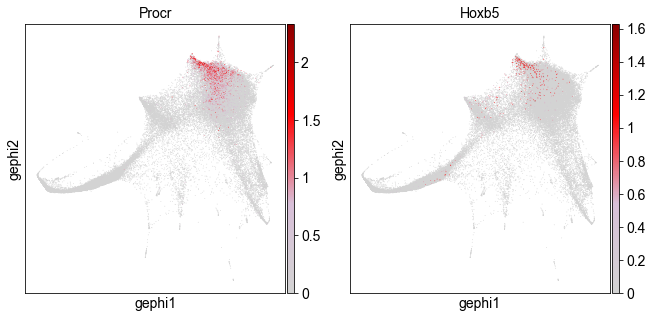

In [27]:
# Specify colourmap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred'])

dahlin_adata_log_norm = dahlin_adata.copy()
sc.pp.normalize_total(dahlin_adata_log_norm)
sc.pp.log1p(dahlin_adata_log_norm)
sc.pl.scatter(dahlin_adata_log_norm, basis='gephi', color=['Procr', 'Hoxb5'], color_map=cmap)
del dahlin_adata_log_norm

In [28]:
# Subset for molo genes and normalise data for input into trained models
dahlin_adata_molo_rank = dahlin_adata.copy()
dahlin_adata_molo_rank = sc.AnnData(dahlin_adata_molo_rank[:, wilson_adata_molo_rank.var_names])
dahlin_adata_molo_rank.X = dahlin_adata_molo_rank.X.toarray()
dahlin_adata_molo_rank = rank_normalise_genes(dahlin_adata_molo_rank)

dahlin_adata_molo_total_count = dahlin_adata.copy()
dahlin_adata_molo_total_count = sc.AnnData(dahlin_adata_molo_total_count[:, wilson_adata_molo_rank.var_names])
dahlin_adata_molo_total_count.X = dahlin_adata_molo_total_count.X.toarray()
dahlin_adata_molo_total_count = total_count_normalised(dahlin_adata_molo_total_count, target_sum_molo)

Predict the HSC-score using the models carried forward from previous testing

In [29]:
for model_name, model in top_models.items():

    if 'total_count' in model_name:
        dahlin_predict = model.predict(dahlin_adata_molo_total_count.X)
    
    elif 'rank' in model_name:
        dahlin_predict = model.predict(dahlin_adata_molo_rank.X)
        
    dahlin_adata.obs[model_name] = dahlin_predict

... storing 'exp_group' as categorical


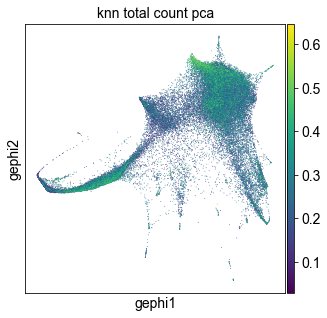

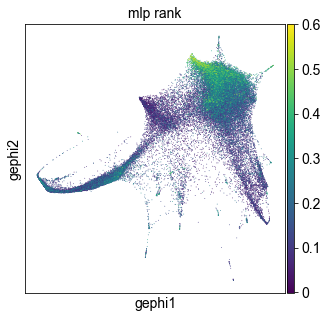

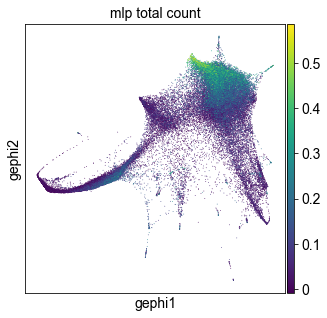

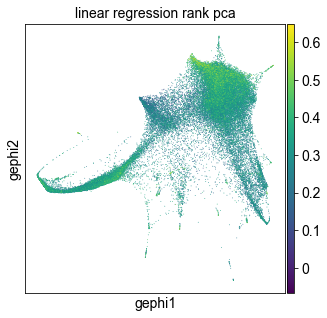

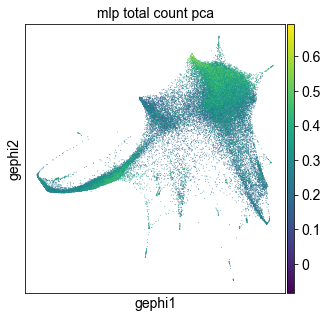

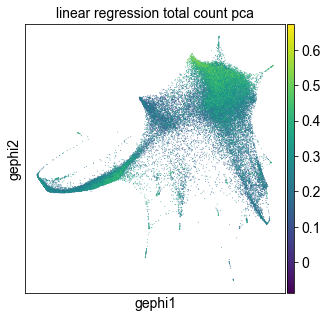

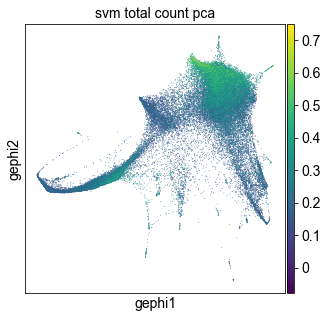

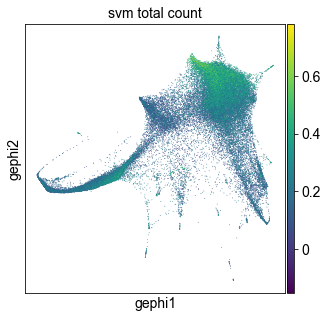

In [30]:
for score, _ in top_models.items():
    sc.pl.scatter(dahlin_adata, basis='gephi', color=score, show=False)

Rule out the models that do not perform well

In [31]:
top_models_in_house = top_models.copy()
top_models_in_house.pop('linear_regression_total_count_pca')
top_models_in_house.pop('mlp_total_count_pca')
top_models_in_house.pop('linear_regression_rank_pca')

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('regr',
                 LinearRegression(copy_X=True, fit_intercept='True',
                                  n_jobs=None, normalize=False))],
         verbose=False)

## Predictions on [Dahlin et al. (2018)](https://doi.org/10.1182/blood-2017-12-821413 ) 10x W<sup>41</sup>/W<sup>41</sup>  data

In Dahlin et al. (2018) we also profiled Lin<sup>-</sup> c-Kit<sup>+</sup> cells from *Kit* mutant W<sup>41</sup>/W<sup>41</sup> mouse bone marrow. These data were also downloaded from GEO submission [GSE107727](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE107727) and the co-ordinates for visulaisation were also obtained from the data website (https://gottgens-lab.stemcells.cam.ac.uk/adultHSPC10X/).

In [32]:
dahlin_adata_w41_SIGAG8 = sc.read(downloaded_data_dir + 'GSM2877133_SIGAG8_counts.txt.gz', cache=True).T
dahlin_adata_w41_SIGAG8.X = sp.sparse.csr_matrix(dahlin_adata_w41_SIGAG8.X)
dahlin_adata_w41_SIGAG8.obs_names = [cell_name + '_SIGAG8' for cell_name in dahlin_adata_w41_SIGAG8.obs_names]

dahlin_adata_w41_SIGAH8 = sc.read(downloaded_data_dir + 'GSM2877134_SIGAH8_counts.txt.gz', cache=True).T
dahlin_adata_w41_SIGAH8.X = sp.sparse.csr_matrix(dahlin_adata_w41_SIGAH8.X)
dahlin_adata_w41_SIGAH8.obs_names = [cell_name + '_SIGAH8' for cell_name in dahlin_adata_w41_SIGAH8.obs_names]

In [33]:
# Concatenate into a single adata object
dahlin_w41_adata = dahlin_adata_w41_SIGAG8.concatenate([dahlin_adata_w41_SIGAH8], index_unique=None)

In [34]:
# Tidy up
del dahlin_adata_w41_SIGAG8
del dahlin_adata_w41_SIGAH8

In [35]:
# Convert gene ensebml ids to gene names
gene_conversion_10x_w41 = gene_conversion_10x.reindex(dahlin_w41_adata.var_names)
dahlin_w41_gene_names = gene_conversion_10x_w41['name']
dahlin_w41_adata.var_names = dahlin_w41_gene_names
dahlin_w41_adata.var_names_make_unique()

In [36]:
# Read in co-ordinates
dahlin_w41_graph_coords = pd.read_csv(downloaded_data_dir + 'coords_W41_LK.txt', index_col=0)

# Use this to filter the adata object to cells that passed QC
dahlin_w41_adata = sc.AnnData(dahlin_w41_adata[dahlin_w41_graph_coords.index, :])

# Add graph coordinates
dahlin_w41_graph_coords = dahlin_w41_graph_coords.loc[dahlin_w41_adata.obs_names]
dahlin_w41_adata.obsm['X_gephi'] = np.array(dahlin_w41_graph_coords)

In [37]:
# Subset for molo genes and normalise
dahlin_w41_adata_molo_rank = dahlin_w41_adata.copy()
dahlin_w41_adata_molo_rank = sc.AnnData(dahlin_w41_adata_molo_rank[:, wilson_adata_molo_rank.var_names])
dahlin_w41_adata_molo_rank.X = dahlin_w41_adata_molo_rank.X.toarray()
dahlin_w41_adata_molo_rank = rank_normalise_genes(dahlin_w41_adata_molo_rank)

dahlin_w41_adata_molo_total_count = dahlin_w41_adata.copy()
dahlin_w41_adata_molo_total_count = sc.AnnData(dahlin_w41_adata_molo_total_count[:, wilson_adata_molo_rank.var_names])
dahlin_w41_adata_molo_total_count.X = dahlin_w41_adata_molo_total_count.X.toarray()
dahlin_w41_adata_molo_total_count = total_count_normalised(dahlin_w41_adata_molo_total_count, target_sum_molo)

Predict HSC-score for the different trained models

In [38]:
for model_name, model in top_models.items():

    if 'total_count' in model_name:
        dahlin_w41_predict = model.predict(dahlin_w41_adata_molo_total_count.X)
    
    elif 'rank' in model_name:
        dahlin_w41_predict = model.predict(dahlin_w41_adata_molo_rank.X)
        
    dahlin_w41_adata.obs[model_name] = dahlin_w41_predict

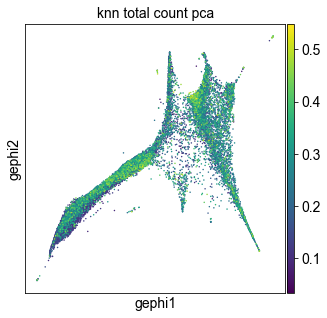

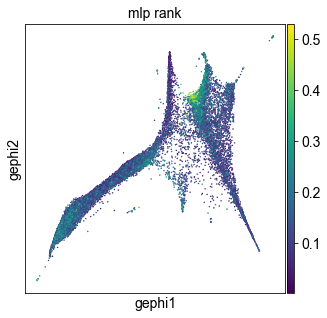

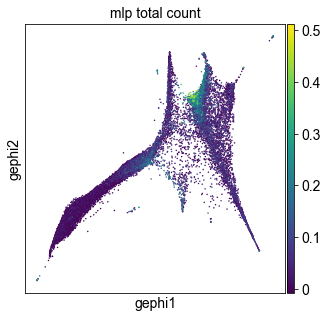

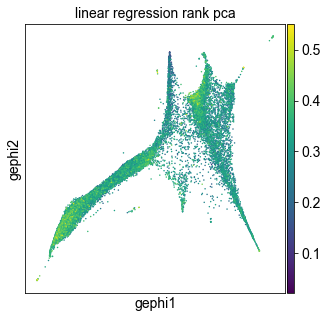

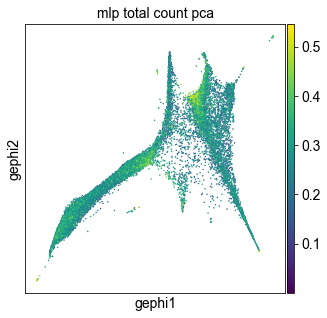

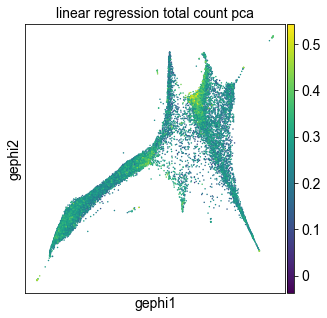

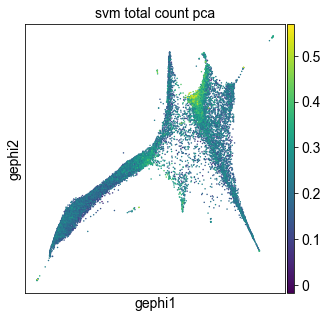

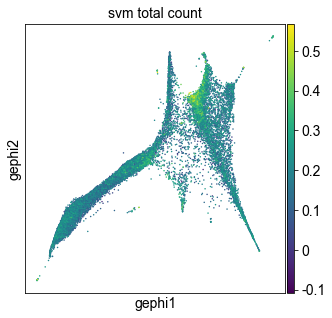

In [39]:
for score, _ in top_models.items():
    sc.pl.scatter(dahlin_w41_adata, basis='gephi', color=score, show=False)

Compare to the Lin<sup>-</sup> c-Kit<sup>+</sup> wild-type data

In [40]:
# Subset for LK data
dahlin_lk_adata = sc.AnnData(dahlin_adata[dahlin_adata.obs['exp_group'] == 'LK'])

# Add coordinate information
graph_coords_wt_lk = pd.read_csv(downloaded_data_dir + 'coords_WT_LK.txt', index_col=0)
graph_coords_wt_lk = graph_coords_wt_lk.loc[dahlin_lk_adata.obs_names]

dahlin_lk_adata.obsm['X_gephi'] = np.array(graph_coords_wt_lk)

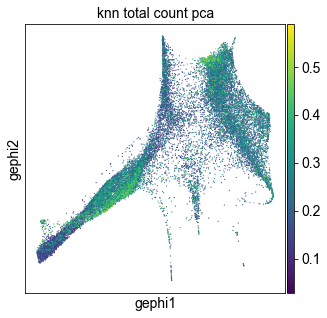

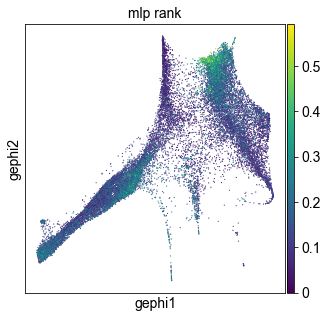

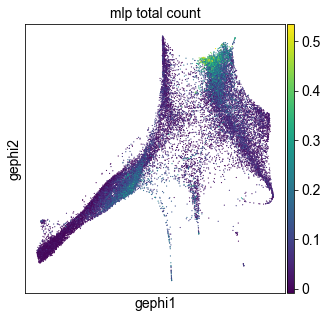

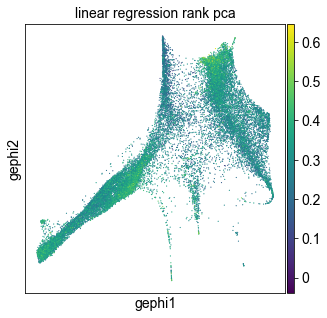

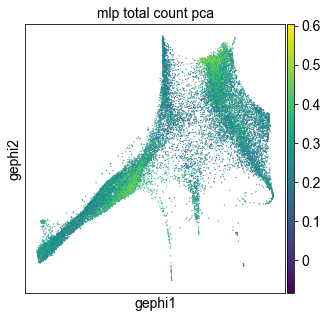

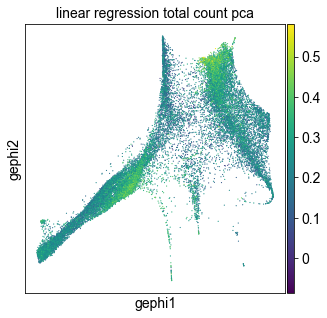

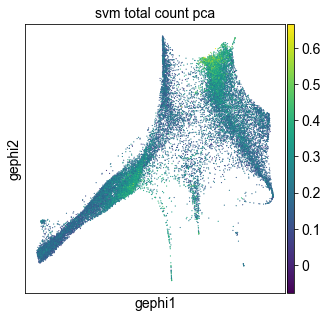

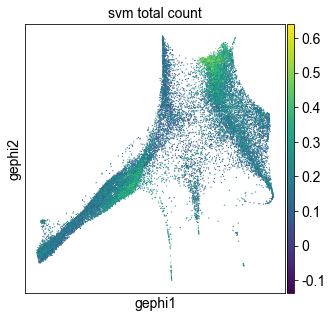

In [41]:
for score, _ in top_models.items():
    sc.pl.scatter(dahlin_lk_adata, basis='gephi', color=score, show=False)

Compare the HSC-score from hscScore model between WT and W<sup>41</sup>/W<sup>41</sup> data

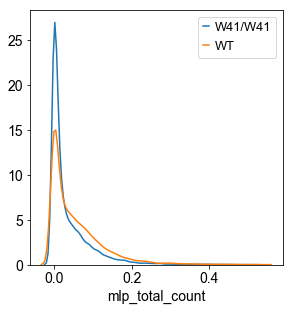

0.51% W41 cells above the threshold of top 1% of WT cells
Ranges of HSC-score
W41: -0.007735495227328595 0.5126974151128928 
 WT: -0.008345307422630163 0.5346200867720994


In [42]:
sns.distplot(dahlin_w41_adata.obs['mlp_total_count'], hist=False, label='W41/W41')
sns.distplot(dahlin_lk_adata.obs['mlp_total_count'], hist=False, label='WT')
plt.legend()
plt.show()

molo_threshold = np.percentile(dahlin_lk_adata.obs['mlp_total_count'], 99)
percent_w41_above_threshold = np.sum(dahlin_w41_adata.obs['mlp_total_count'] > molo_threshold)/dahlin_w41_adata.n_obs*100
print("{:.2f}% W41 cells above the threshold of top 1% of WT cells".format(percent_w41_above_threshold))


print("Ranges of HSC-score")
print("W41:", np.min(dahlin_w41_adata.obs['mlp_total_count']), np.max(dahlin_w41_adata.obs['mlp_total_count']), "\n",
      "WT:", np.min(dahlin_lk_adata.obs['mlp_total_count']), np.max(dahlin_lk_adata.obs['mlp_total_count']))

## Predictions on [Cabezas-Wallscheid et al. (2017)](https://doi.org/10.1016/j.cell.2017.04.018) data

[Cabezas-Wallscheid et al. (2017)](https://doi.org/10.1016/j.cell.2017.04.018) profiled dormant and active HSCs using scRNA-seq. Data were downloaded from the following sources:
- raw_countsHSC_sorted_revision.txt - Counts table downloaded from ArrayExpress accession [E-MTAB-4547](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-4547/) processed data file
- 1-s2.0-S0092867417304646-mmc2.csv - The .xlsx file available in Table S2 of the publication saved as .csv format. This contains information about the highly variable genes identified by the authors

In [43]:
cabezas_adata = sc.read(downloaded_data_dir + 'raw_countsHSC_sorted_revision.txt', first_column_names=True, cache=True).T
cabezas_adata

AnnData object with n_obs × n_vars = 384 × 41220 

Perform quality control on the data

In [44]:
# Filter cells
total_reads = np.sum(cabezas_adata.X, axis=1)
genes_detected = np.array(np.sum(cabezas_adata[:, list(filter(lambda x: 'ENSM' in x, cabezas_adata.var_names))].X > 0, axis=1))
ercc_mapped_reads = np.array(np.sum(cabezas_adata[:, list(filter(lambda x: 'ERCC' in x, cabezas_adata.var_names))].X, axis=1)/total_reads)

cell_filter = np.logical_and(total_reads > 50000, np.logical_and(genes_detected > 1000, ercc_mapped_reads < 0.3))
np.sum(cell_filter)

cabezas_adata = cabezas_adata[cell_filter, :]
cabezas_adata

View of AnnData object with n_obs × n_vars = 316 × 41220 

In [45]:
# Subset to variable genes from the paper for visualisation
cabezas_adata_paper_processed = sc.read(downloaded_data_dir + '1-s2.0-S0092867417304646-mmc2.csv')
cabezas_var_genes = cabezas_adata_paper_processed.var_names
gene_table = pd.read_csv(data_dir + 'ensembl_gene_table_81.txt', index_col=1, sep='\t')
cabezas_var_genes_ids = gene_table.loc[cabezas_var_genes]['Ensembl Gene ID'].values
cabezas_var_genes_ids = [gene for gene in cabezas_var_genes_ids if str(gene) != 'nan']
cabezas_var_genes_ids = cabezas_var_genes_ids + list(filter(lambda x: 'ENSM' in x, cabezas_var_genes))
cabezas_var_genes_ids = list(set(cabezas_var_genes_ids) & set(cabezas_adata.var_names))

cabezas_adata_var = sc.AnnData(cabezas_adata[:, cabezas_var_genes_ids]).copy()

/Users/fiona/miniconda3/envs/hscScore/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


In [46]:
# Convert ensembl ids to gene names
gene_table = pd.read_csv(data_dir + 'ensembl_gene_table_81.txt', index_col=1, sep='\t')
molo_gene_ids = gene_table.loc[wilson_adata_molo_rank.var_names]['Ensembl Gene ID'].values

cabezas_adata_molo = sc.AnnData(cabezas_adata[:, molo_gene_ids])
cabezas_adata_molo.var_names = wilson_adata_molo_rank.var_names

In [47]:
# Subset to molo genes and normalise for input into models
cabezas_adata_molo_rank = cabezas_adata_molo.copy()
cabezas_adata_molo_rank = rank_normalise_genes(cabezas_adata_molo_rank)

cabezas_adata_molo_total_count = cabezas_adata_molo.copy()
cabezas_adata_molo_total_count = total_count_normalised(cabezas_adata_molo_total_count, target_sum_molo)

Predict HSC-score using trained models

In [48]:
for model_name, model in top_models_in_house.items():

    if 'total_count' in model_name:
        cabezas_predict = model.predict(cabezas_adata_molo_total_count.X)
    
    elif 'rank' in model_name:
        cabezas_predict = model.predict(cabezas_adata_molo_rank.X)
        
    cabezas_adata.obs[model_name] = cabezas_predict
    cabezas_adata_var.obs[model_name] = cabezas_predict

Trying to set attribute `.obs` of view, making a copy.


Plot the scores

In [49]:
# Add cell type information for plotting
cell_type = [s.split('_')[1] for s in cabezas_adata.obs_names]
cell_type = ['dHSC' if ct == 'dHSCs' else 'HSC' for ct in cell_type ]
cabezas_adata.obs['cell_type'] = cell_type
cabezas_adata_var.obs['cell_type'] = cell_type
cabezas_adata.uns['cell_type_colors'] = ['green', 'purple']
cabezas_adata_var.uns['cell_type_colors'] = ['green', 'purple']

In [50]:
# Make copy of data for plotting
cabezas_adata_plotting = cabezas_adata_var.copy()

# Normalise data
sc.pp.normalize_per_cell(cabezas_adata_plotting)
sc.pp.log1p(cabezas_adata_plotting)

sc.tl.pca(cabezas_adata_plotting)

... storing 'cell_type' as categorical


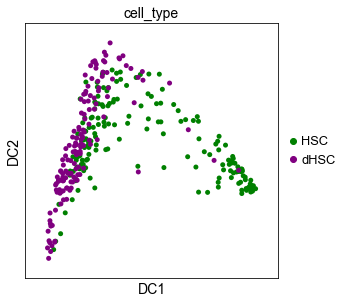

In [51]:
# Diffusion map
sc.pp.neighbors(cabezas_adata_plotting, n_neighbors=30, use_rep='X', method='gauss')
sc.tl.diffmap(cabezas_adata_plotting)
sc.pl.diffmap(cabezas_adata_plotting, color='cell_type', size=100, show=False)

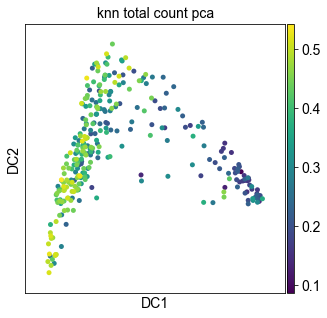

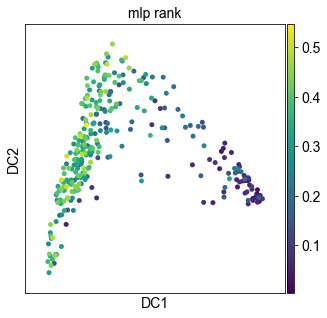

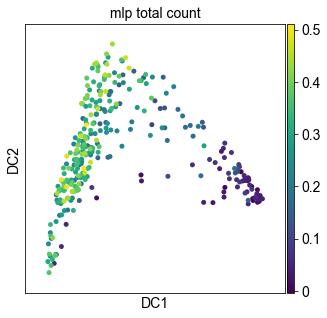

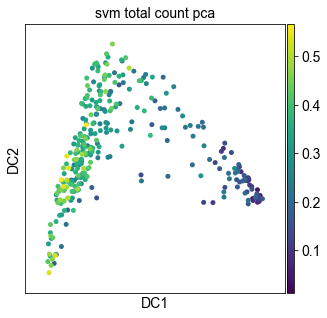

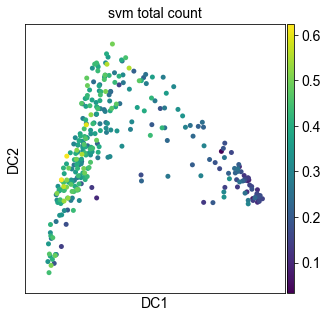

In [52]:
for score, _ in top_models_in_house.items():
    sc.pl.scatter(cabezas_adata_plotting, basis='diffmap', color=score, size=100, show=False)

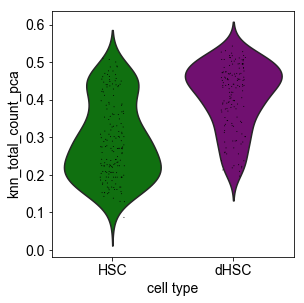

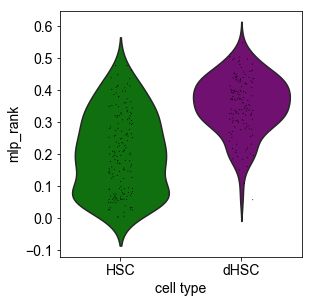

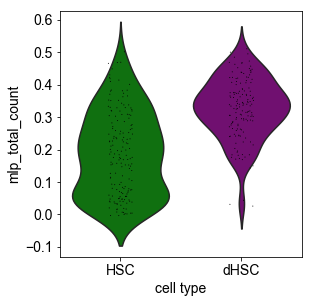

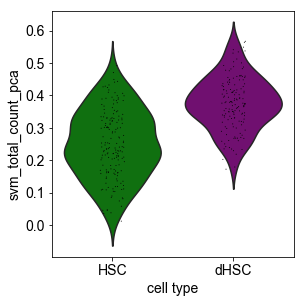

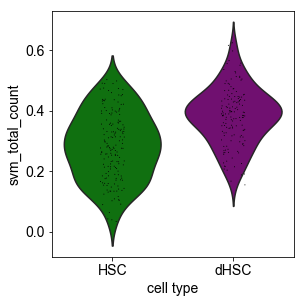

In [53]:
for score, _ in top_models_in_house.items():
    sc.pl.violin(cabezas_adata_plotting, keys=score, groupby='cell_type', show=False,
                 palette=cabezas_adata_plotting.uns['cell_type_colors'])

## Predictions on [Mann et al. (2018)](https://doi.org/10.1016/j.celrep.2018.11.056) data

[Mann et al. (2018)](https://doi.org/10.1016/j.celrep.2018.11.056) profiled LT-HSCs, ST-HSCs and MPPs using the Smart-Seq2 protocol. These data were downloaded from GEO accession number [GSE100428](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100426).
- GSE100426_SC_counts.txt.gz - Count data for [Mann et al. (2018)](https://doi.org/10.1016/j.celrep.2018.11.056)

In [54]:
mann_adata = sc.read(downloaded_data_dir + 'GSE100426_SC_counts.txt.gz', cache=True).T
mann_adata

AnnData object with n_obs × n_vars = 2112 × 23366 

Perform some quality control

In [55]:
sc.pp.filter_cells(mann_adata, min_genes=2000)
mann_adata

AnnData object with n_obs × n_vars = 1529 × 23366 
    obs: 'n_genes'

In [56]:
# Subset molo genes and normalise for model input
mann_adata_molo_rank = mann_adata.copy()
mann_adata_molo_rank = sc.AnnData(mann_adata_molo_rank[:, wilson_adata_molo_rank.var_names])
mann_adata_molo_rank = rank_normalise_genes(mann_adata_molo_rank)

mann_adata_molo_total_count = mann_adata.copy()
mann_adata_molo_total_count = sc.AnnData(mann_adata_molo_total_count[:, wilson_adata_molo_rank.var_names])
mann_adata_molo_total_count = total_count_normalised(mann_adata_molo_total_count, target_sum_molo)

Predict HSC-score using trained models

In [57]:
for model_name, model in top_models_in_house.items():

    if 'total_count' in model_name:
        mann_predict = model.predict(mann_adata_molo_total_count.X)
    
    elif 'rank' in model_name:
        mann_predict = model.predict(mann_adata_molo_rank.X)
        
    mann_adata.obs[model_name] = mann_predict

Plot data

In [58]:
# Add cell type, age and stimulation information from meta data in cell names
cell_type = [s.split('_')[0] for s in mann_adata.obs_names]
age = ['young' if 'young' in s else 'old' for s in mann_adata.obs_names]
stimulation = ['unstimulated' if 'nostim' in s else 'stimulated' for s in mann_adata.obs_names]

unique_condition = [cell_type[i] + '_' + age[i] + '_' + stimulation[i] for i in range(len(cell_type))]

mann_adata.obs['cell_type'] = pd.Categorical(cell_type, categories=['LT', 'ST', 'MPP'])
mann_adata.obs['age'] = age
mann_adata.obs['stimulation'] = stimulation
mann_adata.obs['unique_condition'] = pd.Categorical(unique_condition,
                                                    categories=['LT_old_unstimulated', 'ST_old_unstimulated',
                                                                'MPP_old_unstimulated',
                                                                'LT_young_unstimulated', 'ST_young_unstimulated',
                                                                'MPP_young_unstimulated',
                                                                'LT_old_stimulated', 'ST_old_stimulated',
                                                                'MPP_old_stimulated',
                                                                'LT_young_stimulated', 'ST_young_stimulated',
                                                                'MPP_young_stimulated'])

Trying to set attribute `.var` of view, making a copy.
... storing 'age' as categorical
... storing 'stimulation' as categorical


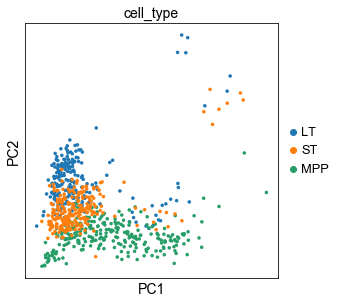

In [59]:
# Make copy of data for plotting
mann_adata_plotting = mann_adata.copy()
mann_adata_plotting_unstim = mann_adata[mann_adata.obs['stimulation'] == 'unstimulated', :]

# Filter to highly variable genes
sc.pp.filter_genes_dispersion(mann_adata_plotting_unstim)

# Normalise data
sc.pp.normalize_per_cell(mann_adata_plotting_unstim)
sc.pp.log1p(mann_adata_plotting_unstim)

sc.tl.pca(mann_adata_plotting_unstim)
sc.pl.pca(mann_adata_plotting_unstim, color=['cell_type'], size=50)

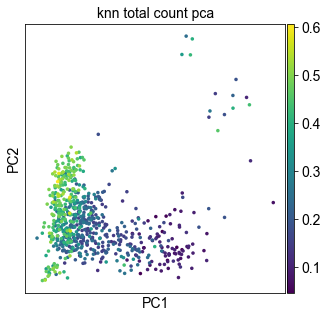

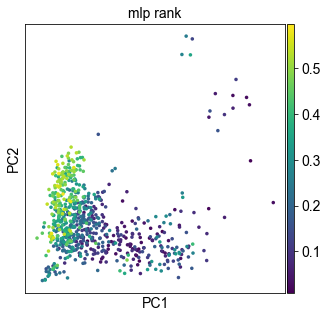

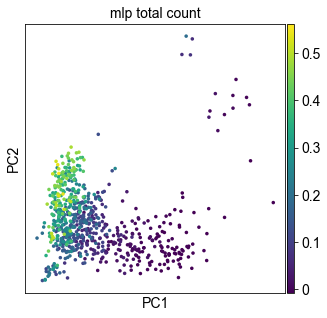

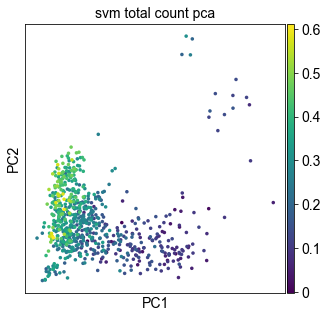

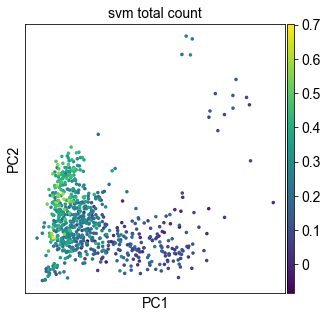

In [60]:
for score, _ in top_models_in_house.items():
    sc.pl.scatter(mann_adata_plotting_unstim, basis='pca', color=score, size=50)

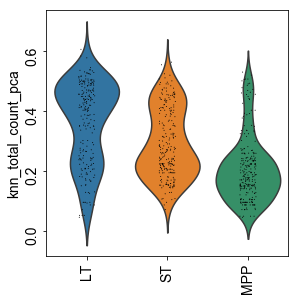

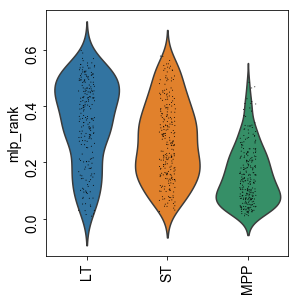

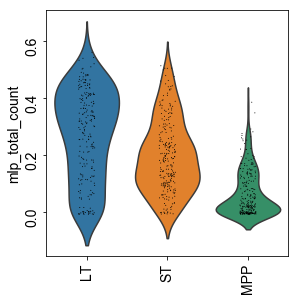

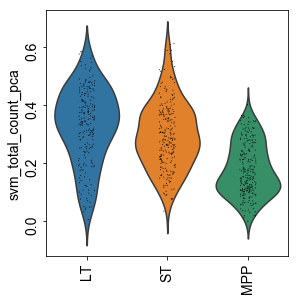

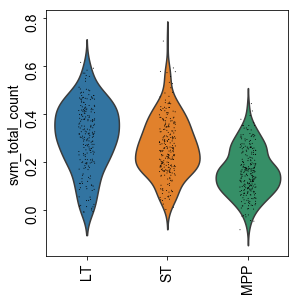

In [61]:
for score, _ in top_models_in_house.items():
    sc.pl.violin(mann_adata_plotting_unstim,
                 keys=score, groupby='cell_type', rotation=90, show=False)

## Predictions on [Rodriguez-Fraticelli et al. (2018)](https://doi.org/10.1038/nature25168) data

[Rodriguez-Fraticelli et al. (2018)](https://doi.org/10.1038/nature25168) used [inDrops](https://doi.org/10.1016/j.cell.2015.04.044) to profile LT-HSC, ST-HSC, MPP2, MPP3 and MPP4 populations. These data can be downloaded from GEO accession [GSE90742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100426).
- GSM2411664_LTHSC.raw_umifm_counts.csv.gz - Counts for LT-HSCs
- GSM2411665_MPP2.raw_umifm_counts.csv.gz - Counts for MPP2s
- GSM2411666_MPP3.raw_umifm_counts.csv.gz - Counts for MPP3s
- GSM2411667_MPP4.raw_umifm_counts.csv.gz - Counts for MPP4s
- GSM2411668_STHSC.raw_umifm_counts.csv.gz - Counts for ST-HSCs

Read in data. Due to formatting of these data we read in, combine to make scanpy adata file, and then save this file for future use

In [60]:
# Number for filename
i = 3

for celltype in ['LTHSC', 'MPP2', 'MPP3', 'MPP4', 'STHSC']:
    
    # Iterate number for filename
    i += 1
    
    celltype_file = downloaded_data_dir + 'GSM241166' + str(i) + '_' + celltype + '.raw_umifm_counts.csv.gz'
    
    rodriguez_expression_celltype = np.genfromtxt(celltype_file, delimiter=',', skip_header=1)
    rodriguez_expression_celltype = rodriguez_expression_celltype[:, 5:]
    
    rodriguez_adata_celltype_colnames = np.genfromtxt(celltype_file, delimiter=',', max_rows=1, dtype='str')
    rodriguez_adata_celltype_genenames = rodriguez_adata_celltype_colnames[5:]
    
    rodriguez_adata_celltype_cellinfo = np.genfromtxt(celltype_file, delimiter=',',
                                                      usecols=[0, 1, 2, 3, 4], dtype='str')
    rodriguez_adata_celltype_cellinfo = pd.DataFrame(rodriguez_adata_celltype_cellinfo[1:, :],
                                                     columns=rodriguez_adata_celltype_cellinfo[0, :])

    rodriguez_adata_celltype_cellnames = rodriguez_adata_celltype_cellinfo['cell_id']
    rodriguez_adata_celltype_celltype = rodriguez_adata_celltype_cellinfo['library_id']
    rodriguez_adata_celltype_qc = pd.to_numeric(rodriguez_adata_celltype_cellinfo['pass_filter'])

    rodriguez_adata_celltype = sc.AnnData(rodriguez_expression_celltype)
    rodriguez_adata_celltype.X = sp.sparse.csr_matrix(rodriguez_adata_celltype.X)
    
    rodriguez_adata_celltype.obs_names = rodriguez_adata_celltype_cellnames
    rodriguez_adata_celltype.var_names = rodriguez_adata_celltype_genenames
    
    rodriguez_adata_celltype.obs['celltype'] = [ct for ct in rodriguez_adata_celltype_celltype]
    rodriguez_adata_celltype.obs['pass_qc'] = [qc for qc in rodriguez_adata_celltype_qc]
    
    if celltype == 'LTHSC':
        rodriguez_adata = rodriguez_adata_celltype
    
    else:
        rodriguez_adata = rodriguez_adata.concatenate(rodriguez_adata_celltype)

sc.write('rodriguez_adata_file', rodriguez_adata)

... storing 'celltype' as categorical


In [62]:
rodriguez_adata = sc.read('rodriguez_adata_file')
rodriguez_adata.obs['celltype'] = pd.Categorical(rodriguez_adata.obs['celltype'],
                                                  categories=['LTHSC', 'STHSC', 'MPP2', 'MPP3', 'MPP4'])

# Quality control
rodriguez_adata = rodriguez_adata[np.array([qc == 1 for qc in rodriguez_adata.obs['pass_qc']]), :]

sc.pp.filter_cells(rodriguez_adata, min_genes=1000)
rodriguez_adata

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 3682 × 28205 
    obs: 'batch', 'celltype', 'pass_qc', 'n_genes'

In [63]:
# Subset to molo genes and normalise for model input
rodriguez_adata_molo_rank = rodriguez_adata.copy()
rodriguez_adata_molo_rank = sc.AnnData(rodriguez_adata_molo_rank[:, wilson_adata_molo_rank.var_names])
rodriguez_adata_molo_rank.X = rodriguez_adata_molo_rank.X.toarray()
rodriguez_adata_molo_rank = rank_normalise_genes(rodriguez_adata_molo_rank)

rodriguez_adata_molo_total_count = rodriguez_adata.copy()
rodriguez_adata_molo_total_count = sc.AnnData(rodriguez_adata_molo_total_count[:, wilson_adata_molo_rank.var_names])
rodriguez_adata_molo_total_count.X = rodriguez_adata_molo_total_count.X.toarray()
rodriguez_adata_molo_total_count = total_count_normalised(rodriguez_adata_molo_total_count, target_sum_molo)

Predict HSC-scores with models

In [64]:
for model_name, model in top_models_in_house.items():

    if 'total_count' in model_name:
        rodriguez_predict = model.predict(rodriguez_adata_molo_total_count.X)
    
    elif 'rank' in model_name:
        rodriguez_predict = model.predict(rodriguez_adata_molo_rank.X)
        
    rodriguez_adata.obs[model_name] = rodriguez_predict

Plot data

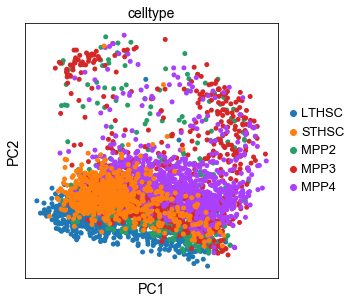

In [65]:
# Make copy of data for plotting
rodriguez_adata_plotting = rodriguez_adata.copy()

# Filter to highly variable genes
sc.pp.filter_genes_dispersion(rodriguez_adata_plotting)

# Normalise data
sc.pp.normalize_per_cell(rodriguez_adata_plotting)
sc.pp.log1p(rodriguez_adata_plotting)

#sc.pp.scale(rodriguez_adata_plotting)

sc.tl.pca(rodriguez_adata_plotting)
sc.pl.pca(rodriguez_adata_plotting, color=['celltype'], size=100)

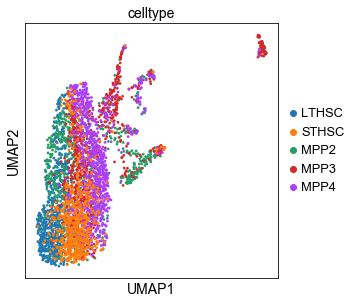

In [67]:
# Calculate other visualisations
sc.pp.neighbors(rodriguez_adata_plotting)

sc.tl.umap(rodriguez_adata_plotting, random_state=7)
sc.pl.umap(rodriguez_adata_plotting, color=['celltype'], size=30)

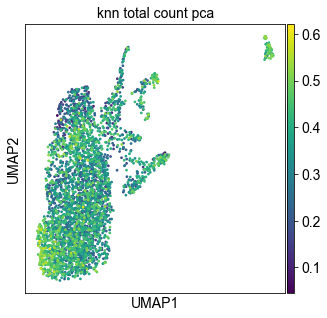

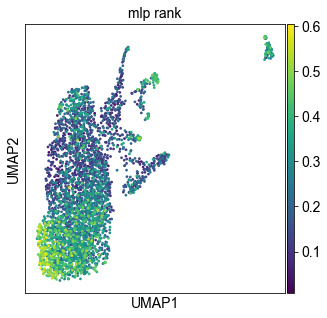

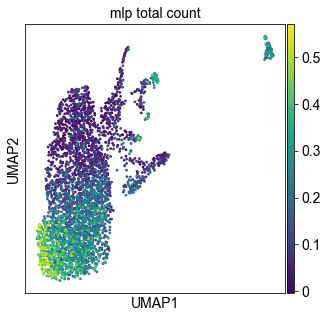

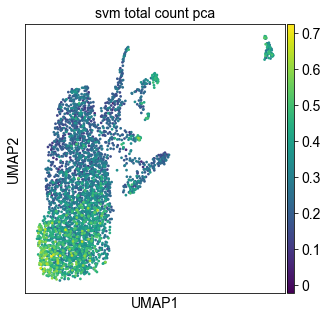

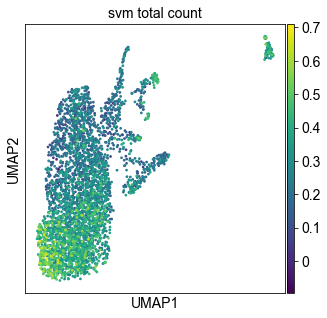

In [68]:
for score, _ in top_models_in_house.items():
    sc.pl.scatter(rodriguez_adata_plotting, basis='umap', color=score, size=30)

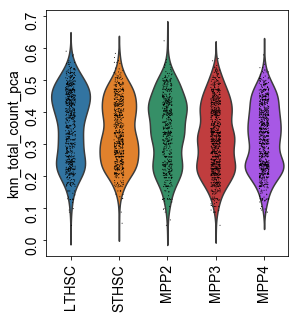

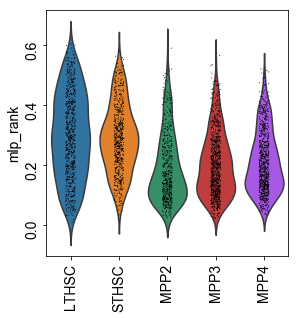

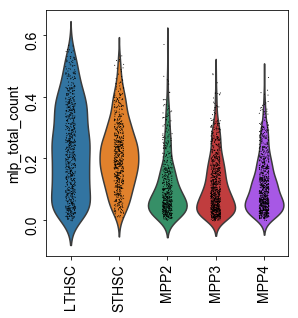

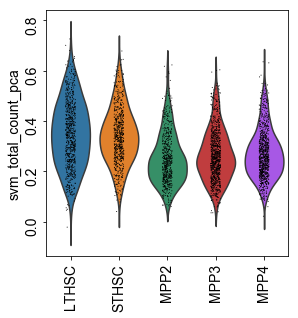

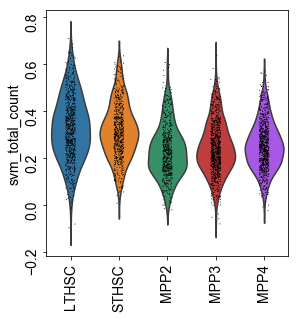

In [69]:
for score, _ in top_models_in_house.items():
    sc.pl.violin(rodriguez_adata_plotting, keys=score, groupby='celltype', rotation=90,
                 order=['LTHSC', 'STHSC', 'MPP2', 'MPP3', 'MPP4'])

## Compare hscScore to averaging gene expression

In [70]:
molo_genes = pd.read_csv(data_dir + 'wilson_nomo_molo_genes.csv')
molo_gene_list =  [gene for gene in wilson_counts.var_names if gene in list(molo_genes['Gene'])]

def molo_score_naive(adata, norm=False):
    
    adata = adata.copy()
    
    if norm == False:
        sc.pp.normalize_per_cell(adata)
    
    # Filter adata to just the MolO genes
    molo_score_genes = molo_genes.loc[molo_genes['Description'] == 'MolO']['Gene']
    molo_expression = adata[:, molo_score_genes].X
    
    if issparse(molo_expression):
        molo_expression = molo_expression.toarray()
    
    # Calculate MolO score as in Dahlin et al 2018
    n_molo = len(molo_score_genes)
    transform_molo_expression = np.log(molo_expression + 1)/n_molo
    #molo_expression_score = np.exp(np.sum(transform_molo_expression, axis=1))
    molo_expression_score = np.sum(transform_molo_expression, axis=1)
    
    return(molo_expression_score)

### Nestorowa et al. (2016) data

Compare to naive MolO scoring

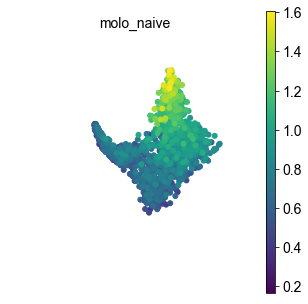

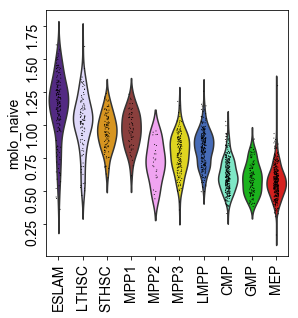

In [71]:
nestorowa_molo_naive = molo_score_naive(nestorowa_adata)
nestorowa_adata.obs['molo_naive'] = nestorowa_molo_naive

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax = sc.pl.diffmap(nestorowa_adata, components='2,0,1', color=['molo_naive'],
                   projection='3d', show=False, size=100, alpha=1, ax=ax, edgecolor='face')
ax.grid(False)
ax.view_init(10, 150)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.axis('off')

sc.pl.violin(nestorowa_adata, keys='molo_naive', groupby='cell_type', rotation=90,
             palette=nestorowa_adata.uns['cell_type_colors'])

### Dahlin et al. (2018) data

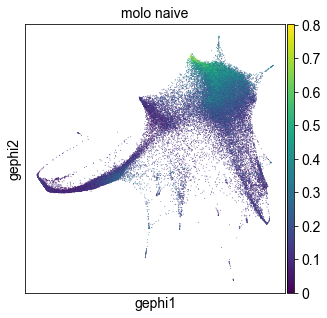

In [72]:
dahlin_molo_naive = molo_score_naive(dahlin_adata)
dahlin_adata.obs['molo_naive'] = dahlin_molo_naive

sc.pl.scatter(dahlin_adata, basis='gephi', color='molo_naive', show=False)

### Cabezas-Wallscheid et al. (2017) data

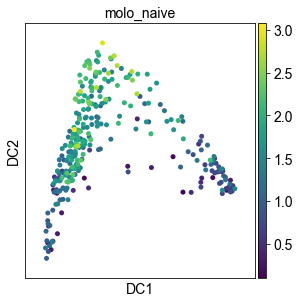

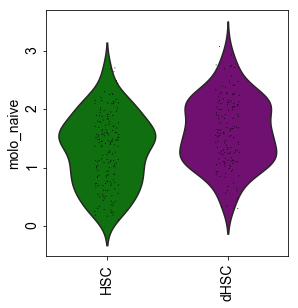

In [73]:
cabezas_adata_norm = sc.pp.normalize_per_cell(cabezas_adata, copy=True)
cabezas_adata_molo_norm = sc.AnnData(cabezas_adata_norm[:, molo_gene_ids])
cabezas_adata_molo_norm.var_names = wilson_adata_molo_rank.var_names

cabezas_molo_naive = molo_score_naive(cabezas_adata_molo_norm)
cabezas_adata_plotting.obs['molo_naive'] = cabezas_molo_naive

sc.pl.diffmap(cabezas_adata_plotting, color='molo_naive', size=100, show=False)

sc.pl.violin(cabezas_adata_plotting, keys='molo_naive', groupby='cell_type', rotation=90,
             show=False, palette=cabezas_adata_plotting.uns['cell_type_colors'])

### Mann et al. (2018) data

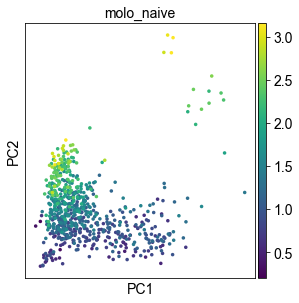

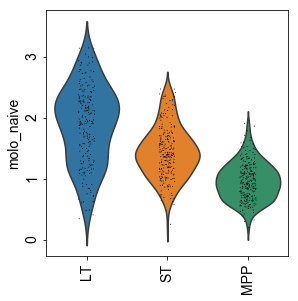

In [74]:
mann_molo_naive = molo_score_naive(mann_adata)
mann_adata_plotting_unstim.obs['molo_naive'] = mann_molo_naive[mann_adata.obs['stimulation'] == 'unstimulated']

sc.pl.pca(mann_adata_plotting_unstim, color='molo_naive', size=50, show=False)

sc.pl.violin(mann_adata_plotting_unstim, keys='molo_naive', groupby='cell_type', rotation=90,
             show=False, stripplot=True)

### Rodriguez-Fraticelli et al. (2018) data

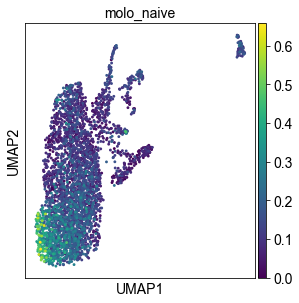

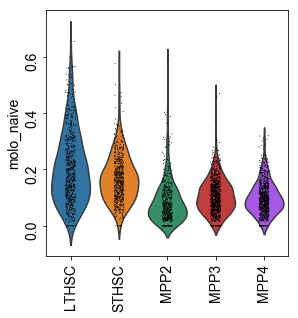

In [75]:
rodriguez_molo_naive = molo_score_naive(rodriguez_adata)
rodriguez_adata.obs['molo_naive'] = rodriguez_molo_naive
rodriguez_adata_plotting.obs['molo_naive'] = rodriguez_molo_naive

sc.pl.umap(rodriguez_adata_plotting, color='molo_naive', show=False)

sc.pl.violin(rodriguez_adata, keys='molo_naive', groupby='celltype', rotation=90,
             show=False, stripplot=True)